# Kobe Bryant helicopter: Flight path data

### Load Python tools

In [1]:
import pandas as pd
import geopandas as gpd
import glob
import os
import altair as alt
from shapely.geometry import Point, LineString, shape

### Get all the flight data from flightradar24's directory.

In [2]:
# urls = \
#     ['https://secure.flightradar24.com/N72EX/2018_10/',
#     'https://secure.flightradar24.com/N72EX/2018_11/',
#     'https://secure.flightradar24.com/N72EX/2018_12/',
#     'https://secure.flightradar24.com/N72EX/2019_01/',
#     'https://secure.flightradar24.com/N72EX/2019_02/',
#     'https://secure.flightradar24.com/N72EX/2019_03/',
#     'https://secure.flightradar24.com/N72EX/2019_04/',
#     'https://secure.flightradar24.com/N72EX/2019_05/',
#     'https://secure.flightradar24.com/N72EX/2019_06/',
#     'https://secure.flightradar24.com/N72EX/2019_07/',
#     'https://secure.flightradar24.com/N72EX/2019_08/',
#     'https://secure.flightradar24.com/N72EX/2019_09/',
#     'https://secure.flightradar24.com/N72EX/2019_10/',
#     'https://secure.flightradar24.com/N72EX/2019_11/',
#     'https://secure.flightradar24.com/N72EX/2019_12/',
#     'https://secure.flightradar24.com/N72EX/2020_01/']

In [3]:
# !cd input
# !unzip \*.zip
# !rm -f *.zip

### What does a flight file look like? 

In [4]:
a_flight = pd.read_csv('input/paths/20200126_598114379.csv')
a_flight.head(10)

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk
0,1579998328,375,301,33.66856,-117.87932,9795,74,0
1,1579998340,575,300,33.67126,-117.88470,9795,91,0
2,1579998352,700,295,33.67387,-117.89081,9795,115,0
3,1579998362,800,301,33.67653,-117.89687,9795,126,0
4,1579998371,850,301,33.67950,-117.90269,9795,132,4300
5,1579998378,900,300,33.68156,-117.90678,9795,134,4300
6,1579998387,950,300,33.68455,-117.91283,9795,136,4300
7,1579998398,1075,300,33.68807,-117.91996,9795,137,4300
8,1579998408,1175,300,33.69122,-117.92635,9795,136,4300
9,1579998422,1225,300,33.69586,-117.93560,9795,139,4300


In [5]:
a_flight.dtypes

snapshot_id      int64
altitude         int64
heading          int64
latitude       float64
longitude      float64
radar_id         int64
speed            int64
squawk           int64
dtype: object

### Concatenate the flight path files

In [6]:
#set path
path = 'input/paths/'

In [7]:
files = glob.glob(os.path.join(path, "*.csv"))

### Read the csv and create a 'flightid' field so we can track unique flights

In [8]:
file_df = (pd.read_csv(f, encoding = "ISO-8859-1", low_memory=False)\
           .assign(flightid=os.path.basename(f)) for f in files)

In [9]:
concatenated_df = pd.concat(file_df, ignore_index=True)

In [10]:
concatenated_df['flightid'] = concatenated_df['flightid']\
    .str.replace('DL89_','', regex=False)\
    .str.replace('.csv','', regex=False)

### How many flight segments do we have? 

In [11]:
len(concatenated_df)

77091

In [12]:
concatenated_df.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid
0,1558727880,0,271,33.66540,-117.87410,4062,0,0,20190524_547520609
1,1558728111,0,230,33.66537,-117.87434,4062,33,4300,20190524_547520609
2,1558728117,50,178,33.66486,-117.87449,4062,31,4300,20190524_547520609
3,1558728126,275,187,33.66316,-117.87456,4062,46,4300,20190524_547520609
4,1558728132,400,264,33.66179,-117.87674,4062,75,4300,20190524_547520609


### Clean up the dataframe

In [13]:
concatenated_df.columns = concatenated_df.columns.str.strip().str.lower().str.replace(' ', '_', regex=False)\
                    .str.replace('(', '', regex=False).str.replace(')', '', regex=False).str.replace('-','_', regex=False)

In [14]:
flights = pd.DataFrame(concatenated_df.sort_values(by='snapshot_id', ascending=False))
flights.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid
68898,1579998831,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379
68897,1579998823,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379
68896,1579998816,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379
68895,1579998807,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379
68894,1579998800,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379


### Split location field into lat, lon to create a geodataframe

In [15]:
flights['latitude'] = flights['latitude'].astype(float)
flights['longitude'] = flights['longitude'].astype(float)

### Convert the UTC date string into an actual datetime series

In [16]:
flights['date_time'] = pd.to_datetime(flights['snapshot_id'],unit='s')

In [17]:
flights['utc_datetime'] = pd.to_datetime(flights['date_time'], format='%Y-%m-%dT%H:%M:%SZ').dt.tz_localize('UTC')

### Localize to Los Angeles time

In [18]:
flights['datetime_pst'] = flights['utc_datetime'].dt.tz_convert('America/Los_Angeles')

In [19]:
flights.head()

,snapshot_id,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,date_time,utc_datetime,datetime_pst
68898,1579998831,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379,2020-01-26 00:33:51,2020-01-26 00:33:51+00:00,2020-01-25 16:33:51-08:00
68897,1579998823,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379,2020-01-26 00:33:43,2020-01-26 00:33:43+00:00,2020-01-25 16:33:43-08:00
68896,1579998816,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379,2020-01-26 00:33:36,2020-01-26 00:33:36+00:00,2020-01-25 16:33:36-08:00
68895,1579998807,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379,2020-01-26 00:33:27,2020-01-26 00:33:27+00:00,2020-01-25 16:33:27-08:00
68894,1579998800,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379,2020-01-26 00:33:20,2020-01-26 00:33:20+00:00,2020-01-25 16:33:20-08:00


### In case we need simplier date/time fields

In [20]:
flights['date'] = pd.to_datetime(flights['datetime_pst']).dt.strftime('%m/%d/%Y')
flights['time'] = pd.to_datetime(flights['datetime_pst']).dt.strftime('%H:%M:%S')
flights['display_time'] = pd.to_datetime(flights['datetime_pst']).dt.strftime('%I:%M %p')
flights['weekday'] = flights['datetime_pst'].dt.day_name()

### Lighten the dataframe a bit

In [21]:
flights.drop(['utc_datetime', 'datetime_pst', 'snapshot_id', 'display_time'], axis=1, inplace=True)

In [22]:
flights.head()

,altitude,heading,latitude,longitude,radar_id,speed,squawk,flightid,date_time,date,time,weekday
68898,0,271,33.81313,-118.16036,2958,49,4300,20200126_598114379,2020-01-26 00:33:51,01/25/2020,16:33:51,Saturday
68897,50,271,33.81289,-118.15881,2958,49,4300,20200126_598114379,2020-01-26 00:33:43,01/25/2020,16:33:43,Saturday
68896,75,272,33.81285,-118.15672,2958,53,4300,20200126_598114379,2020-01-26 00:33:36,01/25/2020,16:33:36,Saturday
68895,100,267,33.81285,-118.15401,2958,60,4300,20200126_598114379,2020-01-26 00:33:27,01/25/2020,16:33:27,Saturday
68894,125,270,33.81294,-118.15163,2958,62,4300,20200126_598114379,2020-01-26 00:33:20,01/25/2020,16:33:20,Saturday


### Export the dataframe as a CSV

In [23]:
flights.to_csv('output/all_flights.csv')

---

## Geography

### Let's convert our flights data to a geodataframe

In [24]:
flights_grouped = flights.groupby('flightid').size().reset_index(name='count')

In [25]:
flights_grouped_clean = flights_grouped[flights_grouped['count'] > 100]

In [26]:
filtered = flights_grouped_clean.flightid.to_list()

In [27]:
flights_filtered = flights[flights.flightid.isin(filtered)]

In [28]:
flights_geo = gpd.GeoDataFrame(flights_filtered, geometry=gpd.points_from_xy(flights_filtered['longitude'], flights_filtered['latitude']))

<AxesSubplot:>

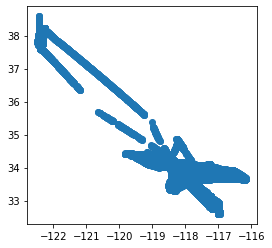

In [29]:
flights_geo.plot()

### We need flight paths. Convert to points to linestring

In [30]:
flights_geo_line = flights_geo.groupby(['flightid', 'date'])['geometry']\
    .apply(lambda x: LineString(x.tolist()) if x.size > 1 else x.tolist()).reset_index()

<AxesSubplot:>

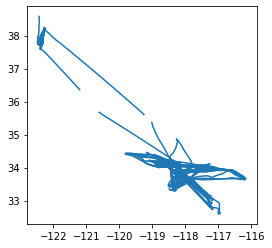

In [31]:
flights_geo_line.plot()

In [32]:
flights_geo_line.to_file('../data/geo/kobe_flight/kobe_flights.geojson', driver='GeoJSON')

In [33]:
flights_geo_line['date'] = pd.to_datetime(flights_geo_line['date'])

<AxesSubplot:>

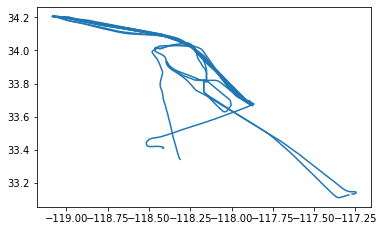

In [34]:
flights_geo_line[flights_geo_line['date'] > '2020-01-01'].plot()

---

### Final flight

In [35]:
final_flight = gpd.read_file('../data/geo/kobe_flight/kobe_final_flight.geojson')

In [36]:
final_flight_points = gpd.read_file('../data/geo/kobe_flight/kobe_final_flight_points.geojson')

In [37]:
final_flight_points.head()

,timestamp,utc,callsign,position,altitude,speed,direction,latitude,longitude,utc_datetime,datetime,date,time,display_time,weekday,geometry
0,1580060729,2020-01-26T17:45:29+00:00,N72EX,"34.135498,-118.699608",1700,153,120,34.135498,-118.699608,2020-01-26T17:45:29,2020-01-26T09:45:29,01/26/2020,09:45:29,09:45:00,Sunday,POINT (-118.69961 34.13550)
1,1580060723,2020-01-26T17:45:23+00:00,N72EX,"34.138824,-118.703407",2050,127,163,34.138824,-118.703407,2020-01-26T17:45:23,2020-01-26T09:45:23,01/26/2020,09:45:23,09:45:00,Sunday,POINT (-118.70341 34.13882)
2,1580060715,2020-01-26T17:45:15+00:00,N72EX,"34.14304,-118.703323",2125,110,207,34.143040,-118.703323,2020-01-26T17:45:15,2020-01-26T09:45:15,01/26/2020,09:45:15,09:45:00,Sunday,POINT (-118.70332 34.14304)
3,1580060708,2020-01-26T17:45:08+00:00,N72EX,"34.145741,-118.701096",1950,111,225,34.145741,-118.701096,2020-01-26T17:45:08,2020-01-26T09:45:08,01/26/2020,09:45:08,09:45:00,Sunday,POINT (-118.70110 34.14574)
4,1580060700,2020-01-26T17:45:00+00:00,N72EX,"34.148861,-118.697037",1750,115,233,34.148861,-118.697037,2020-01-26T17:45:00,2020-01-26T09:45:00,01/26/2020,09:45:00,09:45:00,Sunday,POINT (-118.69704 34.14886)


### Altitude

In [38]:
alt.Chart(final_flight_points).mark_line().encode(
    x='datetime:T',
    y='altitude'
)

### Speed

In [39]:
alt.Chart(final_flight_points).mark_line().encode(
    x='datetime:T',
    y='speed'
)

### Export meta data

In [41]:
final_flight_points[['datetime', 'altitude', 'speed']].to_csv('../data/geo/kobe_flight/kobe_flight_meta.csv', index=False)